In [2]:
import cProfile
import os
import pickle
import pstats
import re
import time
from collections import namedtuple, defaultdict
from typing import List
from multiprocessing import Pool
import networkx as NX
import pandas as pds
import matplotlib.pyplot as plt
import itertools
import math
import re
import statistics
from pprint import pprint

import rich.progress
import scipy
from scipy import stats as scistats
from sklearn import linear_model, preprocessing
from tabulate import tabulate
from pathlib import Path
import pickle
import random
import argparse
import sys

import data_types
from db_actions import db_actions
import numpy as np
from my_yaml import yaml_load, yaml_dump
from alive_progress import alive_bar
import seaborn as sns
from data_types import PickleOut
import commons
import rich.status
from rich.pretty import pprint
from rich import inspect


In [3]:
rc = commons.rc

In [4]:
TR = namedtuple('TableRow', ["cluster", "wfName", "method", "res"])
BigTR = namedtuple("BigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType"])
CVBigTR = namedtuple("CVBigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType", "cvSplit"])
CVUBigTR = namedtuple("CVUBigTableRow", [
    "regModel",
    "cluster",
    "clusterSize",
    "wfName",
    "method",
    "res",
    #"schedCat",
    #"schedType",
    "cvSplit",
    "ukSplit"])

In [5]:
shortToLongNameLUT = {'Linear'       : 'Ordinary Least Squares',
                      'SVR-linear'   : 'SVR - linear',
                      'SVR-poly'     : 'SVR - poly',
                      'SVR-rbf'      : 'SVR - rbf',
                      'SVR-sigmoid'  : 'SVR - sigmoid',
                      'Lasso'        : 'Lasso',
                      'LassoCV'      : 'Lasso CV',
                      'Ridge'        : 'Ridge',
                      'RidgeCV'      : 'Ridge CV',
                      'ElasticNet'   : 'Elastic Net',
                      'ElasticNetCV' : 'Elastic Net CV',
                      'BayesianRidge': 'Bayesian Ridge',
                      'ARD'          : 'Automatic Relevance Determination',
                      'SGD'          : 'Stochastic Gradient Descent',
                      'PA'           : 'Passive Aggressive',
                      'Huber'        : 'Huber',
                      'TheilSen'     : 'Theil Sen'}

In [6]:
def load_from_file(f, prog: rich.progress.Progress, barid):
    modelDegLUT = {
        'linModel' : 1,
        'quadModel': 2,
        'cubeModel': 3,
        'tetModel' : 4,
        'penModel' : 5
    }
    shorterMethodNamesLUT = {
        'randomScheduler'     : 'random',
        'recommenderScheduler': 'recommender'
    }
    pFile = Path(f)
    with open(pFile, "br") as tmp:
        pl: dict = pickle.load(tmp)
    #
    m = re.match("(?:.*/)*(.*Model)\.(.*)_CV-(.*)_U-(.*)\.recSchedTimes\.pickle", f)
    modelDeg = modelDegLUT[m.group(1)]
    modelName = shortToLongNameLUT[m.group(2)]
    shortName = f"{modelDeg} / {modelName}"
    cvSplit = m.group(3)
    if cvSplit == "None":
        cvSplit = None
    ukSplit = m.group(4)
    if ukSplit == "None":
        ukSplit = None
    # for pre, deg in modelDegLUT.items():
    #     if pre in shortName:
    #         shortName = shortName.replace(pre + ".", f"{deg}/")
    #         break
    fmt = CVUBigTR
    #
    prog.reset(barid, total=len(pl.items()))
    for clusterName, cluster in pl.items():
        for wfName, wf in cluster.items():
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            for methodName, res in wf.items():
                for longN, rep in shorterMethodNamesLUT.items():
                    if longN in methodName:
                        mName = methodName.replace(longN, rep)
                        break
                rowInfo = {
                    "regModel"   : shortName,
                    "cluster"    : str(clusterName),
                    "clusterSize": len(clusterName),
                    "wfName"     : wfShortName,
                    "method"     : mName,
                    #"schedCat"   : "recommenderV1,-H1,-H2,-H3" if "V1" in mName else "recommenderV2,-H1,-H2,-H3",
                    #"schedType"  : mName,
                    "cvSplit"    : cvSplit,
                    "ukSplit"    : ukSplit
                }
                if type(res) != list:
                    rowInfo["res"] = float(res)
                    yield fmt(**rowInfo)
                # else:
                #     rowInfo["regModel"] = "N/A"
                #     rowInfo["schedCat"] = "random"
                #     rowInfo["schedType"] = "random"
                #     randomPs = [1, 2, 3]
                #     for i, r in enumerate(res):  # this only applies to the results of the randomScheduler(V1)
                #         if i + 1 in randomPs:
                #             rowInfo["method"] = mName + f"P{i * 10}"
                #             rowInfo["res"] = float(r)
                #             yield fmt(**rowInfo)
                #     rowInfo["method"] = mName + "Avg"
                #     rowInfo["res"] = float(statistics.mean(res))
                #     yield fmt(**rowInfo)
        prog.advance(barid)
    del pl


def load_random_from_files(d, prog: rich.progress.Progress, barid):
    if type(d) is str:
        d = Path(d)
    #
    refFile = d.joinpath(os.listdir(d)[0])
    with open(refFile, "br") as tmp:
        refP: dict = pickle.load(tmp)
    #
    fmt = CVUBigTR
    cls = list(refP.keys())
    wfs = list(refP[cls[0]].keys())
    del refP
    prog.reset(barid, total=len(cls) * len(wfs))
    pls = list()
    for fName in os.listdir(d):
        pFile = d.joinpath(fName)
        with open(pFile, "br") as tmp:
            pl: dict = pickle.load(tmp)
        for clusterName, cluster in pl.items():
            for wfName, wf in cluster.items():
                for methodName in list(wf.keys()):
                    if not "random" in methodName:
                        del pl[clusterName][wfName][methodName]
        #
        pls.append(pl)
        del pl
    for clusterName in cls:
        for wfName in wfs:
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            #
            randoms = [x for pl in pls for x in pl[clusterName][wfName]["randomSchedulerV1"]]
            for pl in pls:
                del pl[clusterName][wfName]
            randoms.sort()
            indices = [int(round(len(randoms) - 1 - x * (len(randoms) - 1), 0)) for x in [a / 10 for a in range(0, 11)]]
            randoms = [x for i, x in enumerate(randoms) if i in indices]
            rowInfo = {
                "regModel"   : "N/A",
                "cluster"    : str(clusterName),
                "clusterSize": len(clusterName),
                "wfName"     : wfShortName,
                "method"     : "randomV1",
                #"schedCat"   : "random",
                #"schedType"  : "random",
                "cvSplit"    : "N/A",
                "ukSplit"    : "N/A"
            }
            for i, r in enumerate(randoms):  # this only applies to the results of the randomScheduler(V1)
                rowInfo["method"] = f"randomV1P{i * 10}"
                rowInfo["res"] = float(r)
                yield fmt(**rowInfo)
            rowInfo["method"] = "randomV1Avg"
            rowInfo["res"] = float(statistics.mean(randoms))
            yield fmt(**rowInfo)
            prog.advance(barid)


def load_from_dir(d):
    with commons.stdProgress(rc) as prog:
        # with alive_bar(len(os.listdir(d)), f"Loading recommenderScheduler results from {d}") as bar:
        fileProg = prog.add_task("Files", total=len(os.listdir(d)))
        clusterProg = prog.add_task("Clusters")
        for f in os.listdir(d):
            yield from load_from_file(f"{d}/{f}", prog, clusterProg)
            prog.advance(fileProg)
        randomsProg = prog.add_task("Randoms")
        yield from load_random_from_files(d, prog, randomsProg)

In [7]:
def get_bigtable(saveLoc, btFileLoc):
    btFile = Path(btFileLoc)
    if not btFile.is_file():
        bigtable = pds.DataFrame(load_from_dir(saveLoc), columns=CVUBigTR._fields)
        with open(btFile, "bw") as f:
            pickle.dump(bigtable, f)
    else:
        with open(btFile, "br") as f:
            bigtable = pickle.load(f)
    return bigtable

In [8]:
def save_plot(obj, name, loc="./fig/", **kwargs):
    obj.savefig(f"{loc}{name}.pdf", transparent=True, **kwargs)
    obj.savefig(f"{loc}{name}.png", transparent=True, **kwargs)

# Get the recSchedTimes data

In [9]:
bigtable = get_bigtable("recSchedTimes", "./recSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# bigtable

# Get the cvRecSchedTimes data

In [ ]:
cvBigtable = get_bigtable("cvRecSchedTimes", "./cvRecSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# cvBigtable

In [10]:
wfNames = bigtable.wfName.unique()

In [11]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [12]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)


# trying out new visualisation

In [13]:
def getRegModelMethodScores(fileLoc: Path, table, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep(cur, mini, tol):
            return abs(cur - mini) <= tol

        crit = yep
    if scorer is None:
        def sc(cur, mini, tol):
            return 1

        scorer = sc
    if type(fileLoc) is str:
        fileLoc = Path(fileLoc)
    if fileLoc.is_file():
        with open(fileLoc, "br") as f:
            return pickle.load(f)
    else:
        grouped = table[table.regModel != "N/A"].pivot(["cluster", "wfName", "regModel"], "method", "res")
        clWFCombs = itertools.product(clusters, wfNames)
        numclWFCombs = len(list(clWFCombs))
        clWFCombs = itertools.product(clusters, wfNames)
        rMMethCombs = list(itertools.product(regModels, methods))
        # regModelMethodScores = defaultdict(lambda: 0)
        with commons.stdProgress(rc) as prog:
            cvwfProg = prog.add_task("Cluster/Workflow", total=numclWFCombs)
            regModelMethodScores = defaultdict(lambda: 0)

            for clwf, subtable in grouped.groupby(level=(0, 1), group_keys=False):
                c, wf = clwf
                subtable = subtable.droplevel(["cluster", "wfName"])
                minimumTime = subtable.min().min()
                for rmmetch in rMMethCombs:
                    rM, meth = rmmetch
                    # rc.log(subtable.loc[rM, meth], minimumTime, abs(subtable.loc[rM, meth] - minimumTime), abs(subtable.loc[rM, meth] - minimumTime) <= tol)
                    curr = subtable.loc[rM, meth]
                    if type(tol) is int or type(tol) is float:
                        t = tol
                    else:
                        t = tol(curr, minimumTime)
                    if crit(curr, minimumTime, t):
                        regModelMethodScores[rmmetch] = regModelMethodScores[rmmetch] + scorer(curr, minimumTime, t)
                prog.advance(cvwfProg)
            regModelMethodScores = dict(regModelMethodScores)
        #
        with open(fileLoc, "bw") as f:
            pickle.dump(regModelMethodScores, f)
        return dict(regModelMethodScores)

------

In [14]:
tmp = bigtable[bigtable.regModel != "N/A"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [15]:
confs = dict()
with open("percentileModels", "r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l: PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle", fName.strip())
            confs[f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"] = commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])


In [16]:
confs

{
│   '5 / Ordinary Least Squares': 1.0,
│   '3 / Ridge': 0.9231538458419148,
│   ... +9
}

In [17]:
regModels = sorted(regModels, key=lambda x: confs[x], reverse=True)

In [18]:
pprint(regModels)

[
│   '5 / Ordinary Least Squares',
│   '3 / Ridge',
│   '3 / SVR - linear',
│   '3 / Elastic Net CV',
│   '2 / Ridge CV',
│   '1 / Ordinary Least Squares',
│   '1 / Lasso CV',
│   '1 / SVR - linear',
│   '3 / Elastic Net',
│   '1 / Elastic Net',
│   '4 / Passive Aggressive'
]

In [ ]:
regModelMethodScores = getRegModelMethodScores("regModelMethodScores.pickle", bigtable)

In [49]:
regModelMethodDiffs = getRegModelMethodScores("regModelMethodDiffs.pickle", bigtable, crit=lambda a, b, c: True, scorer=lambda cur, mini, tol: abs(cur - mini))

In [20]:
regModelMethodScores10P = getRegModelMethodScores("regModelMethodScores10P.pickle",
                                                  None,  #bigtable,
                                                  tol=lambda cur, mini: 10 * mini / 100)

In [ ]:
regModelMethodScores

In [50]:
regModelMethodDiffs

{
│   ('5 / Ordinary Least Squares', 'recommenderV1'): 239649005.83414665,
│   ('5 / Ordinary Least Squares', 'recommenderV1H1'): 275930202.1803047,
│   ... +86
}

In [22]:
regModelMethodScores10P

{
│   ('1 / Lasso CV', 'recommenderV1'): 35744,
│   ('1 / Lasso CV', 'recommenderV1H1'): 35850,
│   ... +86
}

-------------

In [23]:
regModelMethodScoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores.items():
    rM, meth = rm
    regModelMethodScoresDF.loc[rM, meth] = s

In [24]:
regModelMethodScoresDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,25731.0,27353.0,27353.0,28508.0,9615.0,9903.0,9903.0,9654.0
3 / Ridge,9628.0,10563.0,10563.0,11010.0,6874.0,6824.0,6824.0,6643.0
3 / SVR - linear,5818.0,6311.0,6311.0,6909.0,5492.0,5875.0,5875.0,5797.0
3 / Elastic Net CV,7031.0,6694.0,6694.0,6641.0,5087.0,5512.0,5512.0,5272.0
2 / Ridge CV,5328.0,5502.0,5502.0,5439.0,5277.0,5668.0,5668.0,5445.0
1 / Ordinary Least Squares,5369.0,5422.0,5422.0,5116.0,4605.0,5089.0,5089.0,4854.0
1 / Lasso CV,5346.0,5516.0,5516.0,5329.0,4467.0,4961.0,4961.0,4766.0
1 / SVR - linear,4731.0,5343.0,5343.0,5141.0,4179.0,4546.0,4546.0,4344.0
3 / Elastic Net,5347.0,4954.0,4954.0,4851.0,3742.0,4000.0,4000.0,3851.0
1 / Elastic Net,3789.0,4030.0,4030.0,4232.0,2613.0,2895.0,2895.0,2833.0


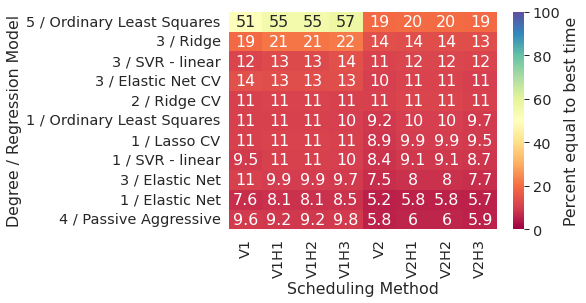

In [25]:
# normalize
total = 50_000
tmp = regModelMethodScoresDF.transform(lambda x: 100 * x / total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodScoresDF.columns],
                 cbar_kws={"label": "Percent equal to best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmapBIS", bbox_inches="tight")
plt.show()

In [26]:
regModelMethodScores10PDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores10P.items():
    rM, meth = rm
    regModelMethodScores10PDF.loc[rM, meth] = s

In [27]:
regModelMethodScores10PDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,43509.0,43304.0,43304.0,44438.0,37449.0,36687.0,36687.0,36050.0
3 / Ridge,42956.0,42587.0,42587.0,43463.0,37101.0,35902.0,35902.0,34888.0
3 / SVR - linear,38292.0,39259.0,39259.0,40567.0,35636.0,34450.0,34450.0,33553.0
3 / Elastic Net CV,38136.0,38746.0,38746.0,39246.0,34599.0,34365.0,34365.0,32863.0
2 / Ridge CV,37002.0,38431.0,38431.0,38518.0,35209.0,35127.0,35127.0,33285.0
1 / Ordinary Least Squares,33601.0,34683.0,34683.0,34709.0,33180.0,33224.0,33224.0,31051.0
1 / Lasso CV,35744.0,35850.0,35850.0,35905.0,32357.0,32831.0,32831.0,30720.0
1 / SVR - linear,33344.0,34826.0,34826.0,34813.0,32533.0,32668.0,32668.0,30441.0
3 / Elastic Net,34241.0,33357.0,33357.0,33455.0,30570.0,29937.0,29937.0,27852.0
1 / Elastic Net,30086.0,30887.0,30887.0,30790.0,27218.0,26728.0,26728.0,25694.0


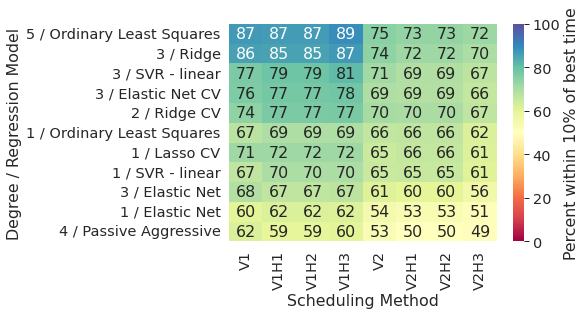

In [28]:
# normalize
total = 50_000
tmp = regModelMethodScores10PDF.transform(lambda x: 100 * x / total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodScores10PDF.columns],
                 cbar_kws={"label": "Percent within 10% of best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmap10P", bbox_inches="tight")
plt.show()

In [51]:
regModelMethodDiffsDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodDiffs.items():
    rM, meth = rm
    regModelMethodDiffsDF.loc[rM, meth] = s

In [52]:
regModelMethodDiffsDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,2.3965e+08,2.7593e+08,2.7593e+08,2.3164e+08,6.6333e+08,5.7857e+08,5.7857e+08,6.1306e+08
3 / Ridge,2.6382e+08,3.0214e+08,3.0214e+08,2.7633e+08,6.9238e+08,5.9636e+08,5.9636e+08,6.5229e+08
3 / SVR - linear,3.7813e+08,3.8018e+08,3.8018e+08,3.4609e+08,7.2483e+08,6.3134e+08,6.3134e+08,6.8597e+08
3 / Elastic Net CV,3.7100e+08,3.9290e+08,3.9290e+08,3.8251e+08,7.4505e+08,5.8901e+08,5.8901e+08,6.6543e+08
2 / Ridge CV,4.1547e+08,4.0576e+08,4.0576e+08,4.0327e+08,7.6519e+08,5.9811e+08,5.9811e+08,6.7828e+08
1 / Ordinary Least Squares,4.7633e+08,4.7585e+08,4.7585e+08,4.7248e+08,8.3087e+08,6.1528e+08,6.1528e+08,7.0887e+08
1 / Lasso CV,4.3125e+08,4.6967e+08,4.6967e+08,4.6468e+08,8.2630e+08,6.0997e+08,6.0997e+08,6.9763e+08
1 / SVR - linear,4.6586e+08,4.6263e+08,4.6263e+08,4.5944e+08,8.1655e+08,6.1574e+08,6.1574e+08,7.0690e+08
3 / Elastic Net,4.2554e+08,4.9394e+08,4.9394e+08,4.8763e+08,8.5908e+08,6.8734e+08,6.8734e+08,7.8869e+08
1 / Elastic Net,5.8913e+08,6.2854e+08,6.2854e+08,6.2123e+08,9.4519e+08,8.2115e+08,8.2115e+08,8.8593e+08


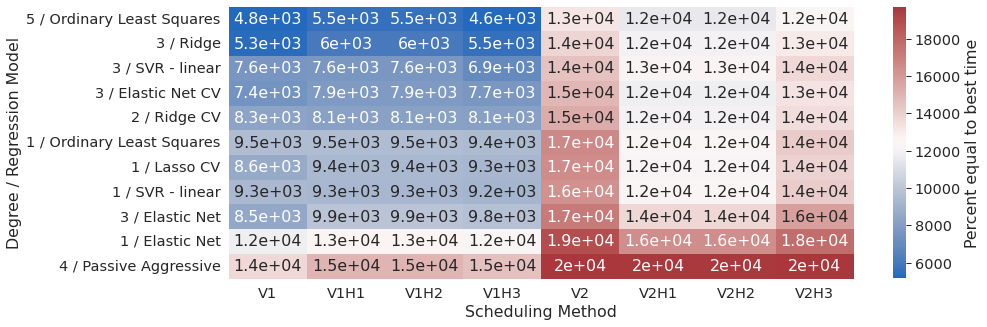

In [63]:
# normalize
total = 50_000
tmp = regModelMethodDiffsDF.transform(lambda x: x / total)
#
plt.figure(figsize=(14,5))
ax = sns.heatmap(tmp,
                 cmap=sns.color_palette("vlag", as_cmap=True),
                 xticklabels=[c.replace("recommender", "") for c in regModelMethodDiffsDF.columns],
                 cbar_kws={"label": "Percent equal to best time"},
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmapDiff", bbox_inches="tight")
plt.show()

------

In [ ]:
tmp = cvBigtable[cvBigtable.regModel != "N/A"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [41]:
confs = dict()
with open("percentileCVModels", "r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l: PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle", fName.strip())
            key = f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"
            p = confs.get(key, list())
            confs[key] = p + [commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])]
for k, l in confs.items():
    confs[k] = commons.jamGeomean(l)


In [42]:
pprint(confs)

{
│   '1 / SVR - rbf': 0.8387889322997693,
│   '1 / Stochastic Gradient Descent': 0.7855591233166146,
│   '3 / SVR - rbf': 0.46743515455075557
}

In [29]:
regModels = ['1 / SVR - rbf', '1 / Stochastic Gradient Descent', '3 / SVR - rbf']  #sorted(regModels, key=lambda x: confs[x], reverse=True)

In [30]:
pprint(regModels)

['1 / SVR - rbf', '1 / Stochastic Gradient Descent', '3 / SVR - rbf']

In [31]:
cvScores = dict()
cv10PScores = dict()
j = 1
for i in itertools.product(wfNames, wfNames):  #cvBigtable[cvBigtable.regModel != "N/A"].groupby(["cvSplit","ukSplit"]):
    if i[0] == i[1]:
        continue
    rc.log(j, i)
    cvScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores_CV-{i[0]}_U-{i[1]}.pickle",
                                          None,  #d.drop(["cvSplit","ukSplit"], axis=1)
                                          )
    cv10PScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores10P_CV-{i[0]}_U-{i[1]}.pickle",
                                             None,  # d.drop(["cvSplit","ukSplit"], axis=1),
                                             tol=lambda cur, mini: 10 * mini / 100)
    j += 1

[22:06:36] 1                                                                  ]8;id=767858;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('sarek', 'methylseq')

           2                                                                  ]8;id=81464;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('sarek', 'chipseq')

           3                                                                  ]8;id=368099;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('sarek', 'eager')

           4                                                                  ]8;id=913706;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('sarek', 'viralrecon')

           5                                                                  ]8;id=880868;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('methylseq', 'sarek')

           6                                                                  ]8;id=595228;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('methylseq', 'chipseq')

           7                                                                  ]8;id=68079;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('methylseq', 'eager')

           8                                                                  ]8;id=446536;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('methylseq', 'viralrecon')

           9                                                                  ]8;id=557421;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('chipseq', 'sarek')

           10                                                                 ]8;id=291308;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('chipseq', 'methylseq')

           11                                                                 ]8;id=921798;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('chipseq', 'eager')

           12                                                                 ]8;id=225206;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('chipseq', 'viralrecon')

           13                                                                 ]8;id=413868;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('eager', 'sarek')

           14                                                                 ]8;id=66564;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('eager', 'methylseq')

           15                                                                 ]8;id=30230;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('eager', 'chipseq')

           16                                                                 ]8;id=748436;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('eager', 'viralrecon')

           17                                                                 ]8;id=732181;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('viralrecon', 'sarek')

           18                                                                 ]8;id=892555;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('viralrecon', 'methylseq')

           19                                                                 ]8;id=610503;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('viralrecon', 'chipseq')

           20                                                                 ]8;id=695522;file:///tmp/ipykernel_11217/1473399348.py\1473399348.py]8;;\:7
           ('viralrecon', 'eager')

In [32]:
#pprint(cvScores)

In [33]:
cv10PScores

{
│   ('sarek', 'methylseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 33536,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 34696,
│   │   ... +22
│   },
│   ('sarek', 'chipseq'): {
│   │   ('1 / SVR - rbf', 'recommenderV1'): 36016,
│   │   ('1 / SVR - rbf', 'recommenderV1H1'): 36726,
│   │   ... +22
│   },
│   ... +18
}

In [34]:
cvRegModelMethodScores = dict()
for _, sc in cvScores.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodScores[rmmeth] = cvRegModelMethodScores.get(rmmeth, 0) + r

In [35]:
cvRegModelMethodScores10P = dict()
for _, sc in cv10PScores.items():
    for rmmeth, r in sc.items():
        cvRegModelMethodScores10P[rmmeth] = cvRegModelMethodScores10P.get(rmmeth, 0) + r

In [36]:
cvRegModelMethodScores

{
│   ('1 / SVR - rbf', 'recommenderV1'): 259713,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 275020,
│   ... +22
}

In [37]:
cvRegModelMethodScores10P

{
│   ('1 / SVR - rbf', 'recommenderV1'): 759588,
│   ('1 / SVR - rbf', 'recommenderV1H1'): 765871,
│   ... +22
}

In [38]:
cvRegModelMethodScoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodScores.items():
    rM, meth = rm
    cvRegModelMethodScoresDF.loc[rM, meth] = s

In [39]:
cvRegModelMethodScoresDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
1 / SVR - rbf,259713.0,275020.0,275020.0,290446.0,198989.0,218629.0,218629.0,205442.0
1 / Stochastic Gradient Descent,197793.0,199337.0,199337.0,197955.0,170579.0,186399.0,186399.0,175455.0
3 / SVR - rbf,197748.0,196185.0,196185.0,208983.0,111865.0,120898.0,120898.0,117597.0


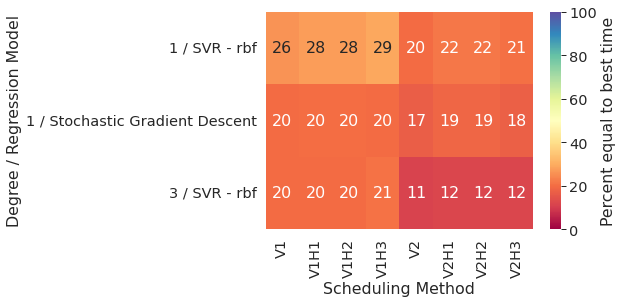

In [40]:
# normalize
total = 20 * 50_000
tmp = cvRegModelMethodScoresDF.transform(lambda x: 100 * x / total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodScoresDF.columns],
                 cbar_kws={"label": "Percent equal to best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "cvHeatmapBIS", bbox_inches="tight")
plt.show()

In [41]:
cvRegModelMethodScores10PDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in cvRegModelMethodScores10P.items():
    rM, meth = rm
    cvRegModelMethodScores10PDF.loc[rM, meth] = s

In [42]:
cvRegModelMethodScores10PDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
1 / SVR - rbf,759588.0,765871.0,765871.0,778016.0,687719.0,683672.0,683672.0,646950.0
1 / Stochastic Gradient Descent,708525.0,722652.0,722652.0,724040.0,656117.0,677033.0,677033.0,631148.0
3 / SVR - rbf,656111.0,650994.0,650994.0,658911.0,550538.0,529632.0,529632.0,516272.0


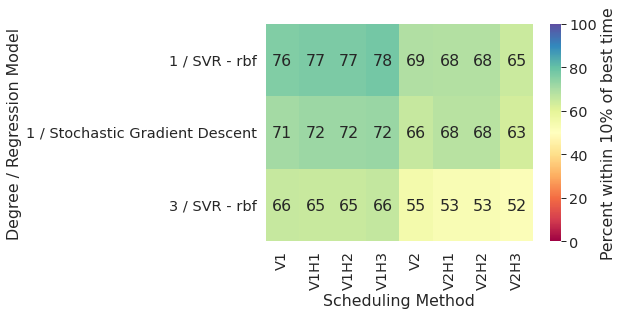

In [43]:
# normalize
total = 20 * 50_000
tmp = cvRegModelMethodScores10PDF.transform(lambda x: 100 * x / total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in cvRegModelMethodScores10PDF.columns],
                 cbar_kws={"label": "Percent within 10% of best time"},
                 vmin=0,
                 vmax=100,
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "cvHeatmap10P", bbox_inches="tight")
plt.show()

------

In [53]:
def compareCVFull(fullTable, cvSplitTable, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep(res, cvres, tol):
            dist = abs(res - cvres)
            if dist <= tol:
                dec = 0
            elif res < cvres:
                dec = -1
            else:
                dec = 1
            return dec

        crit = yep
    if scorer is None:
        def sc(res, cvres, tol):
            return 1

        scorer = sc
    #
    totalTable = fullTable.join(cvSplitTable.set_index(["cluster", "wfName"]), on=["cluster", "wfName"], rsuffix="_cv")
    #
    clWFCombs = itertools.product(clusters, wfNames)
    numclWFCombs = len(list(clWFCombs))
    #
    comp = dict(full=0, equal=0, cv=0)
    with commons.stdProgress(rc) as prog:
        cvwfProg = prog.add_task("Comparing", total=numclWFCombs)

        for row in totalTable.itertuples():
            if type(tol) is int or type(tol) is float:
                t = tol
            else:
                t = tol(row.res, row.res_cv)
            dec = crit(row.res, row.res_cv, t)
            if dec == -1:
                key = "full"
            elif dec == 0:
                key = "equal"
            elif dec == 1:
                key = "cv"
            else:
                raise Exception("crit must return -1, 0, or 1")

            comp[key] = comp[key] + scorer(row.res, row.res_cv, t)
            prog.advance(cvwfProg)
    return comp

In [ ]:
maxi = regModelMethodScoresDF.max().max()
cand = regModelMethodScoresDF.idxmax().reset_index()
cand.columns = ["method", "model"]
bisRmmeth = None
for i in cand.itertuples():
    if regModelMethodScoresDF.loc[i.model, i.method] == maxi:
        bisRmmeth = (i.model, i.method)
        break
bisRmmeth

In [234]:
if Path("bisBigtable.pickle").is_file():
    with open("bisBigtable.pickle", "br") as f:
        bisBigtable = pickle.load(f)
else:
    bisBigtable = bigtable.query("regModel==@bisRmmeth[0] and method==@bisRmmeth[1]")
    #bisBigtable.drop(["regModel", "method", "cvSplit", "ukSplit", "clusterSize"], axis=1)
    with open("bisBigtable.pickle", "bw") as f:
        bisBigtable = pickle.dump(bisBigtable, f)
bisBigtable

,regModel,cluster,clusterSize,wfName,method,res,cvSplit,ukSplit
400003,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,33364.6500,None,None
400011,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,39318.6000,None,None
400019,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,126638.2667,None,None
400027,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,27151.2000,None,None
400035,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,138079.2667,None,None
...,...,...,...,...,...,...,...,...
799963,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,sarek,recommenderV1H3,33356.3500,None,None
799971,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,methylseq,recommenderV1H3,39318.6000,None,None
799979,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,chipseq,recommenderV1H3,126735.6333,None,None
799987,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,eager,recommenderV1H3,27574.6000,None,None


In [235]:
maxi = cvRegModelMethodScoresDF.max().max()
cand = cvRegModelMethodScoresDF.idxmax().reset_index()
cand.columns = ["method", "model"]
bisCVRmmeth = None
for i in cand.itertuples():
    if cvRegModelMethodScoresDF.loc[i.model, i.method] == maxi:
        bisCVRmmeth = (i.model, i.method)
        break
bisCVRmmeth

(
│   '1 / SVR - rbf',
│   'recommenderV1H3'
)

In [236]:
if Path("bisCVBigtable.pickle").is_file():
    with open("bisCVBigtable.pickle", "br") as f:
        bisCVBigtable = pickle.load(f)
else:
    bisCVBigtable = cvBigtable.query("regModel==@bisCVRmmeth[0] and method==@bisCVRmmeth[1]")
    #bisCVBigtable.drop(["regModel", "method", "clusterSize"], axis=1)
    with open("bisCVBigtable.pickle", "bw") as f:
        pickle.dump(bisCVBigtable, f)
bisCVBigtable

,regModel,cluster,clusterSize,wfName,method,res,cvSplit,ukSplit
400003,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,33866.6667,viralrecon,eager
400011,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,39914.7333,viralrecon,eager
400019,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,136622.2000,viralrecon,eager
400027,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,28006.6000,viralrecon,eager
400035,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,150695.5333,viralrecon,eager
...,...,...,...,...,...,...,...,...
20399963,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,sarek,recommenderV1H3,44115.8500,chipseq,eager
20399971,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,methylseq,recommenderV1H3,44736.2667,chipseq,eager
20399979,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,chipseq,recommenderV1H3,184831.8333,chipseq,eager
20399987,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,eager,recommenderV1H3,38532.4000,chipseq,eager


In [55]:
if Path("splitComp.pickle").is_file():
    with open("splitComp.pickle", "br") as f:
        splitComp = pickle.load(f)
else:
    splitComp = dict()
    for split, tab in bisCVBigtable.groupby(["cvSplit", "ukSplit"]):
        rc.log(split)
        splitComp[split] = compareCVFull(bisBigtable, tab.drop(["cvSplit", "ukSplit"], axis=1))
        rc.log(splitComp[split])
    with open("splitComp.pickle", "bw") as f:
        pickle.dump(splitComp, f)
pprint(splitComp)

{
│   ('chipseq', 'eager'): {'full': 29475, 'equal': 15932, 'cv': 4593},
│   ('chipseq', 'methylseq'): {'full': 32719, 'equal': 13238, 'cv': 4043},
│   ('chipseq', 'sarek'): {'full': 33699, 'equal': 13000, 'cv': 3301},
│   ('chipseq', 'viralrecon'): {'full': 33418, 'equal': 13427, 'cv': 3155},
│   ('eager', 'chipseq'): {'full': 36824, 'equal': 9774, 'cv': 3402},
│   ('eager', 'methylseq'): {'full': 36469, 'equal': 10418, 'cv': 3113},
│   ('eager', 'sarek'): {'full': 38179, 'equal': 8526, 'cv': 3295},
│   ('eager', 'viralrecon'): {'full': 32383, 'equal': 13491, 'cv': 4126},
│   ('methylseq', 'chipseq'): {'full': 33501, 'equal': 12751, 'cv': 3748},
│   ('methylseq', 'eager'): {'full': 34859, 'equal': 11823, 'cv': 3318},
│   ('methylseq', 'sarek'): {'full': 36094, 'equal': 10595, 'cv': 3311},
│   ('methylseq', 'viralrecon'): {'full': 31377, 'equal': 15532, 'cv': 3091},
│   ('sarek', 'chipseq'): {'full': 37751, 'equal': 8626, 'cv': 3623},
│   ('sarek', 'eager'): {'full': 37251, 'equal': 9476, 'cv': 3273},
│   ('sarek', 'methylseq'): {'full': 36114, 'equal': 9741, 'cv': 4145},
│   ('sarek', 'viralrecon'): {'full': 35965, 'equal': 11397, 'cv': 2638},
│   ('viralrecon', 'chipseq'): {'full': 32140, 'equal': 14288, 'cv': 3572},
│   ('viralrecon', 'eager'): {'full': 36631, 'equal': 10288, 'cv': 3081},
│   ('viralrecon', 'methylseq'): {'full': 36264, 'equal': 9845, 'cv': 3891},
│   ('viralrecon', 'sarek'): {'full': 36442, 'equal': 9829, 'cv': 3729}
}

In [58]:
col = list()
for split, comp in splitComp.items():
    cv, uk = split
    col.append([cv, uk, comp['full'], comp['equal'], comp['cv']])
compDF = pds.DataFrame(data=col, columns=["cvSplit", "ukSplit", "full", "equal", "cv"])
compDF
compDF.pivot("cvSplit", "ukSplit", "cv")
#print(compDF.pivot("cvSplit", "ukSplit","text").to_latex(na_rep="-"))

ukSplit,chipseq,eager,methylseq,sarek,viralrecon
cvSplit,,,,,
chipseq,NaN,4593.0,4043.0,3301.0,3155.0
eager,3402.0,NaN,3113.0,3295.0,4126.0
methylseq,3748.0,3318.0,NaN,3311.0,3091.0
sarek,3623.0,3273.0,4145.0,NaN,2638.0
viralrecon,3572.0,3081.0,3891.0,3729.0,NaN


In [59]:
if Path("split10PComp.pickle").is_file():
    with open("split10PComp.pickle", "br") as f:
        split10PComp = pickle.load(f)
else:
    split10PComp = dict()
    for split, tab in bisCVBigtable.groupby(["cvSplit", "ukSplit"]):
        rc.log(split)
        split10PComp[split] = compareCVFull(bisBigtable, tab.drop(["cvSplit", "ukSplit"], axis=1), tol=lambda res, cvres: min(res, cvres) * 10 / 100)
        rc.log(split10PComp[split])
    with open("split10PComp.pickle", "bw") as f:
        pickle.dump(split10PComp, f)
pprint(split10PComp)

{
│   ('chipseq', 'eager'): {'full': 5307, 'equal': 44358, 'cv': 335},
│   ('chipseq', 'methylseq'): {'full': 4480, 'equal': 45349, 'cv': 171},
│   ('chipseq', 'sarek'): {'full': 4943, 'equal': 44865, 'cv': 192},
│   ('chipseq', 'viralrecon'): {'full': 8774, 'equal': 41022, 'cv': 204},
│   ('eager', 'chipseq'): {'full': 8046, 'equal': 41784, 'cv': 170},
│   ('eager', 'methylseq'): {'full': 5734, 'equal': 44209, 'cv': 57},
│   ('eager', 'sarek'): {'full': 9686, 'equal': 40166, 'cv': 148},
│   ('eager', 'viralrecon'): {'full': 2532, 'equal': 47368, 'cv': 100},
│   ('methylseq', 'chipseq'): {'full': 5199, 'equal': 44519, 'cv': 282},
│   ('methylseq', 'eager'): {'full': 4441, 'equal': 45437, 'cv': 122},
│   ('methylseq', 'sarek'): {'full': 8217, 'equal': 41663, 'cv': 120},
│   ('methylseq', 'viralrecon'): {'full': 1855, 'equal': 47807, 'cv': 338},
│   ('sarek', 'chipseq'): {'full': 10209, 'equal': 39629, 'cv': 162},
│   ('sarek', 'eager'): {'full': 7398, 'equal': 42450, 'cv': 152},
│   ('sarek', 'methylseq'): {'full': 10990, 'equal': 38890, 'cv': 120},
│   ('sarek', 'viralrecon'): {'full': 7616, 'equal': 42025, 'cv': 359},
│   ('viralrecon', 'chipseq'): {'full': 7265, 'equal': 42451, 'cv': 284},
│   ('viralrecon', 'eager'): {'full': 5313, 'equal': 44513, 'cv': 174},
│   ('viralrecon', 'methylseq'): {'full': 8457, 'equal': 41025, 'cv': 518},
│   ('viralrecon', 'sarek'): {'full': 6373, 'equal': 43436, 'cv': 191}
}

In [63]:
col = list()
for split, comp in split10PComp.items():
    cv, uk = split
    col.append([cv, uk, comp['full'], comp['equal'], comp['cv']])
compDF = pds.DataFrame(data=col, columns=["cvSplit", "ukSplit", "full", "equal", "cv"])
#compDF.pivot("cvSplit", "ukSplit")
#print(compDF.pivot("cvSplit", "ukSplit","text").to_latex(na_rep="-"))
compDF.pivot("cvSplit", "ukSplit", "cv")

ukSplit,chipseq,eager,methylseq,sarek,viralrecon
cvSplit,,,,,
chipseq,NaN,335.0,171.0,192.0,204.0
eager,170.0,NaN,57.0,148.0,100.0
methylseq,282.0,122.0,NaN,120.0,338.0
sarek,162.0,152.0,120.0,NaN,359.0
viralrecon,284.0,174.0,518.0,191.0,NaN


------------

In [237]:
bisBigtable: pds.DataFrame
bisBigtable = bisBigtable.fillna("N/A")
bisBigtable

,regModel,cluster,clusterSize,wfName,method,res,cvSplit,ukSplit
400003,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,33364.6500,N/A,N/A
400011,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,39318.6000,N/A,N/A
400019,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,126638.2667,N/A,N/A
400027,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,27151.2000,N/A,N/A
400035,5 / Ordinary Least Squares,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,138079.2667,N/A,N/A
...,...,...,...,...,...,...,...,...
799963,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,sarek,recommenderV1H3,33356.3500,N/A,N/A
799971,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,methylseq,recommenderV1H3,39318.6000,N/A,N/A
799979,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,chipseq,recommenderV1H3,126735.6333,N/A,N/A
799987,5 / Ordinary Least Squares,"(165, 166, 169, 170, 173, 173, 175, 176, 178, ...",20,eager,recommenderV1H3,27574.6000,N/A,N/A


In [238]:
bisCVBigtable: pds.DataFrame
test = bisCVBigtable
test["split"] = test["cvSplit"] + " / " + test["ukSplit"]
test

,regModel,cluster,clusterSize,wfName,method,res,cvSplit,ukSplit,split
400003,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,33866.6667,viralrecon,eager,viralrecon / eager
400011,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,39914.7333,viralrecon,eager,viralrecon / eager
400019,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,136622.2000,viralrecon,eager,viralrecon / eager
400027,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,28006.6000,viralrecon,eager,viralrecon / eager
400035,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,150695.5333,viralrecon,eager,viralrecon / eager
...,...,...,...,...,...,...,...,...,...
20399963,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,sarek,recommenderV1H3,44115.8500,chipseq,eager,chipseq / eager
20399971,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,methylseq,recommenderV1H3,44736.2667,chipseq,eager,chipseq / eager
20399979,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,chipseq,recommenderV1H3,184831.8333,chipseq,eager,chipseq / eager
20399987,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,eager,recommenderV1H3,38532.4000,chipseq,eager,chipseq / eager


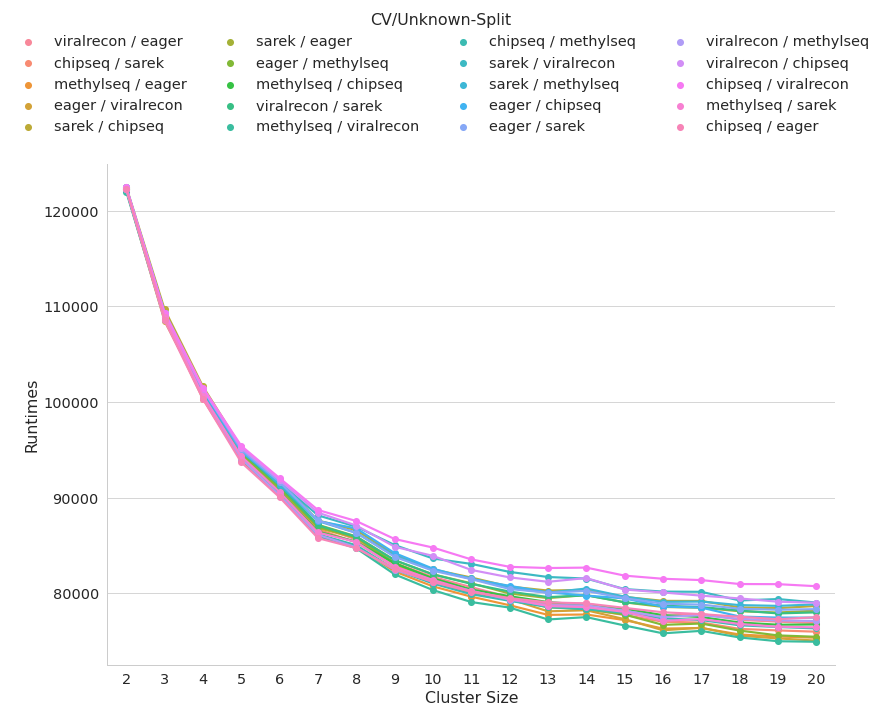

In [259]:
g = sns.catplot(kind="point",
                data=test,
                x="clusterSize",
                y="res",
                aspect=1.5,
                height=8,
                ci=None,
                hue="split")
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="CV/Unknown-Split", frameon=False)
g.set(xlabel="Cluster Size", ylabel="Runtimes")
save_plot(g, "compCV")
plt.show()

-------------

In [266]:
bisCVBigtable["isUk"] = bisCVBigtable.wfName == bisCVBigtable.ukSplit

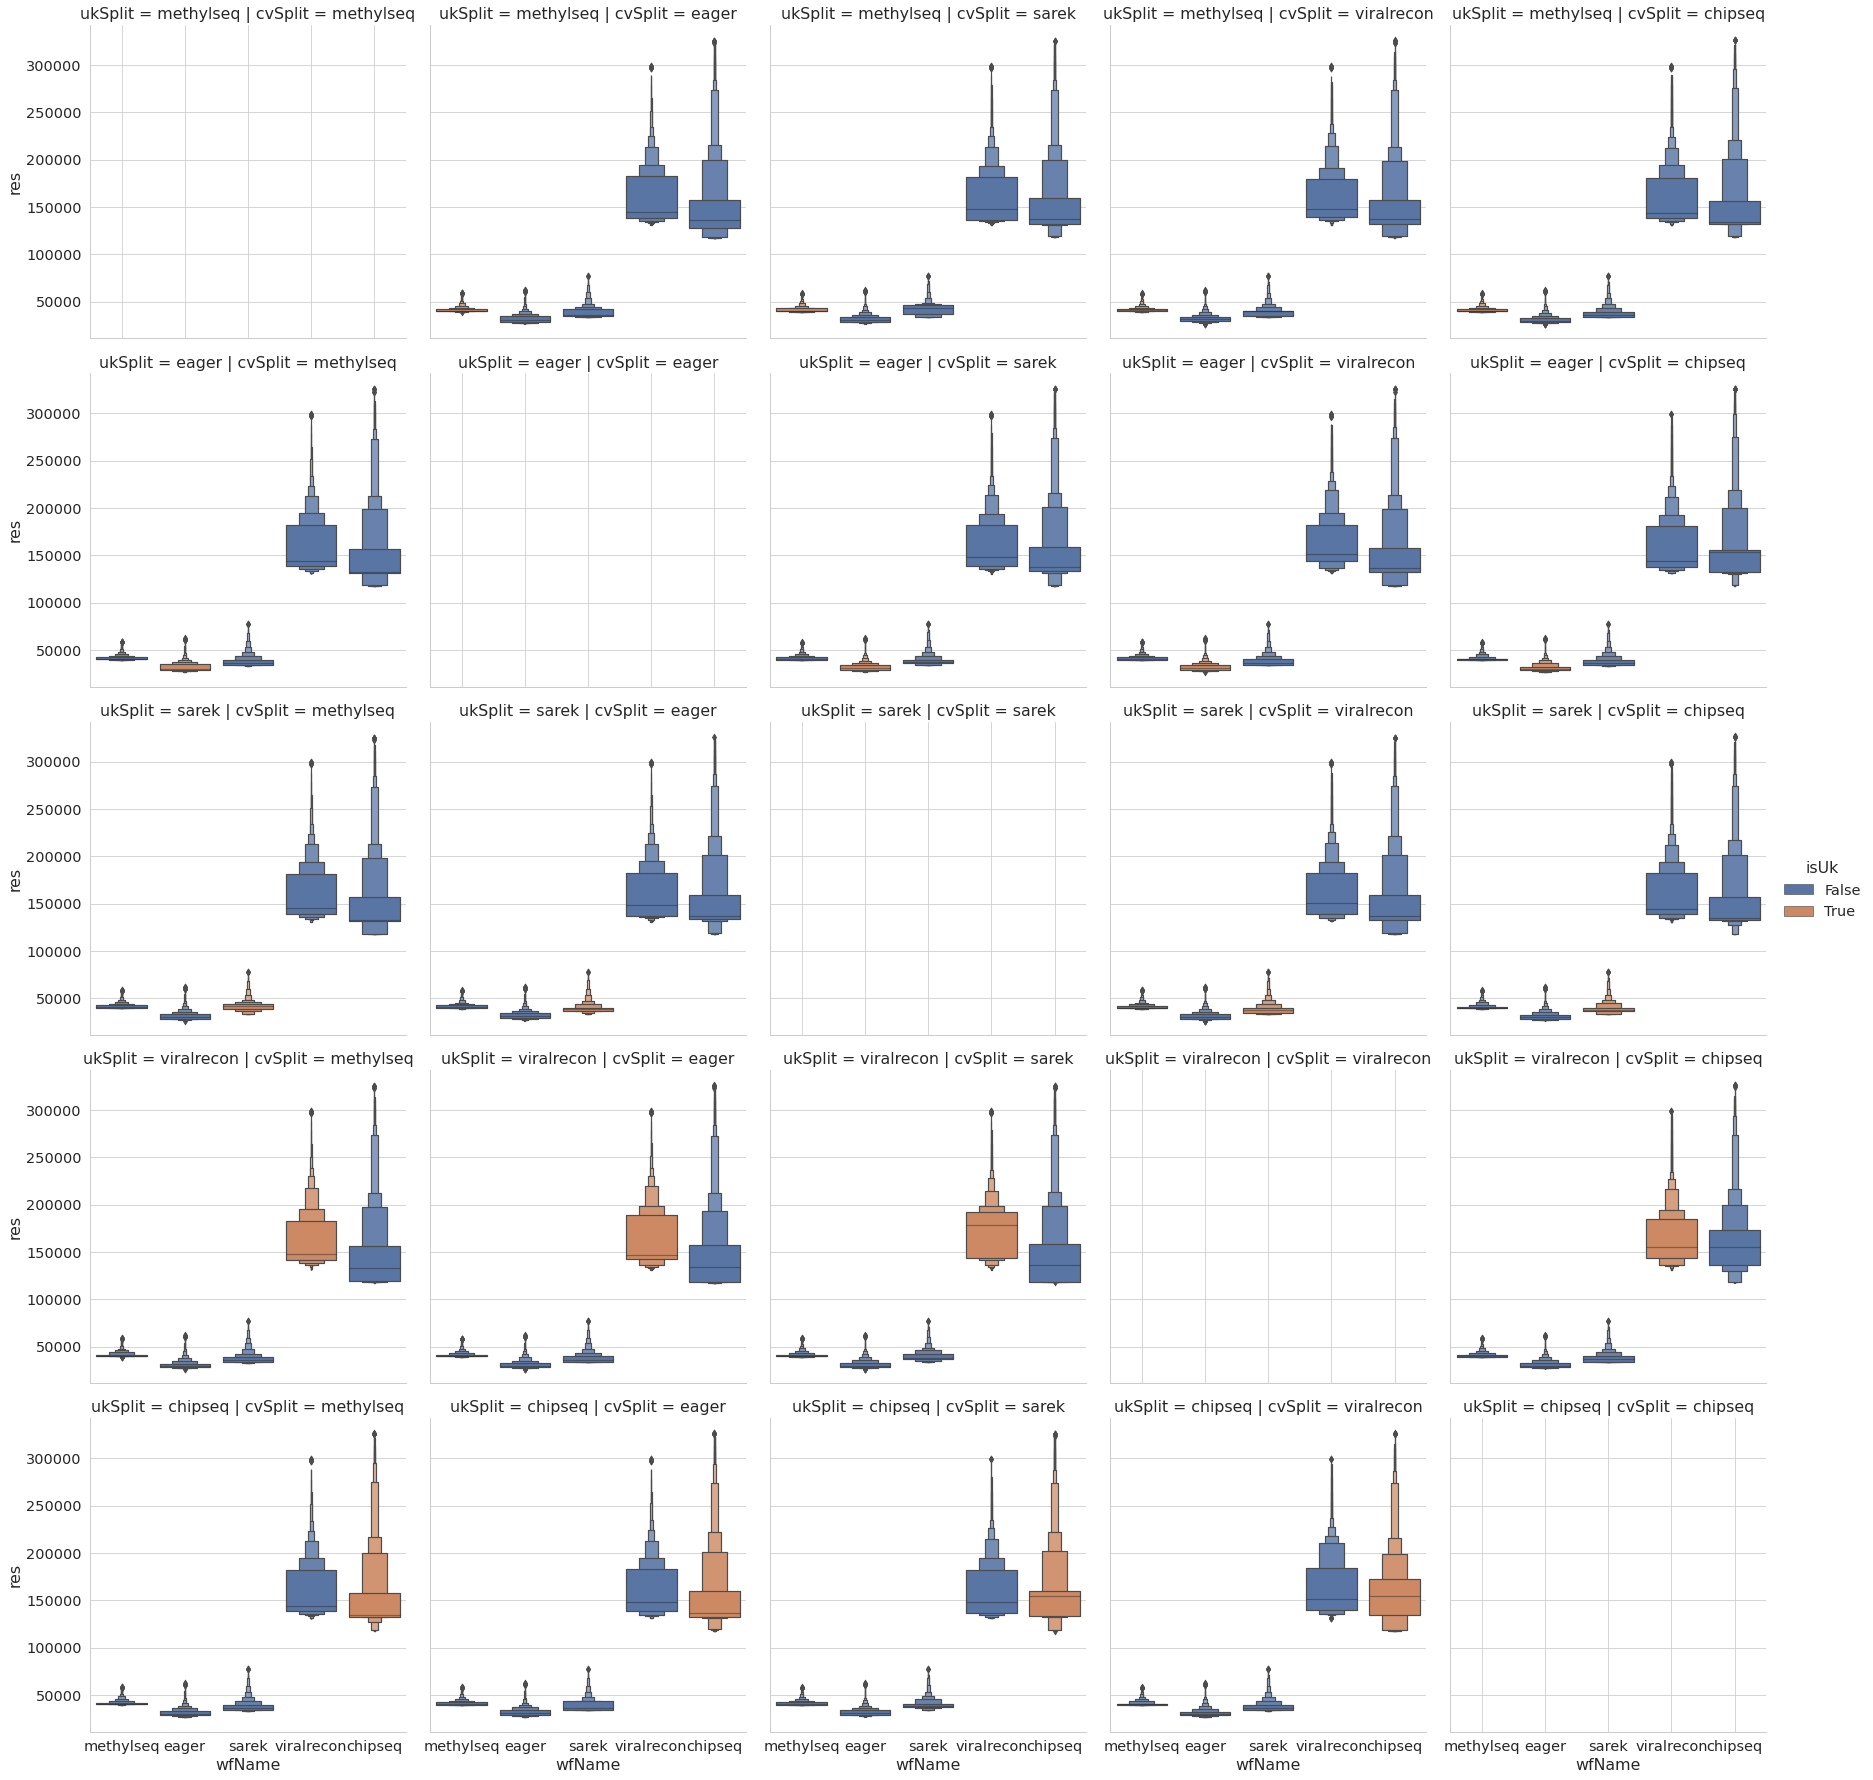

In [268]:
order = ["methylseq", "eager", "sarek", "viralrecon", "chipseq"]
g = sns.catplot(kind="boxen",
                data=bisCVBigtable,
                x="wfName",
                y="res",
                row="ukSplit",
                row_order=order,
                col_order=order,
                order=order,
                dodge=False,
                col="cvSplit",
                hue="isUk"
                )

-------------

In [240]:
t = test.groupby(["wfName", "cluster"])["res"].aggregate(statistics.mean)

In [253]:
c = test[["regModel", "cluster", "clusterSize", "wfName", "method", "cvSplit", "ukSplit", "split"]].join(t, on=["wfName", "cluster"])
c

,regModel,cluster,clusterSize,wfName,method,cvSplit,ukSplit,split,res
400003,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,viralrecon,eager,viralrecon / eager,35792.8617
400011,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,viralrecon,eager,viralrecon / eager,39889.2800
400019,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,viralrecon,eager,viralrecon / eager,136417.1933
400027,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,viralrecon,eager,viralrecon / eager,27935.7600
400035,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,viralrecon,eager,viralrecon / eager,140067.1433
...,...,...,...,...,...,...,...,...,...
20399963,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,sarek,recommenderV1H3,chipseq,eager,chipseq / eager,44603.6350
20399971,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,methylseq,recommenderV1H3,chipseq,eager,chipseq / eager,44678.6700
20399979,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,chipseq,recommenderV1H3,chipseq,eager,chipseq / eager,184795.1733
20399987,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,eager,recommenderV1H3,chipseq,eager,chipseq / eager,36044.4500


In [254]:
c = c[c.split == "viralrecon / eager"]
c["Kind"] = "Average CV"
c["Type"] = "Average CV"
c

/tmp/ipykernel_4584/2699184128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Kind"] = "Average CV"
/tmp/ipykernel_4584/2699184128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c["Type"] = "Average CV"


,regModel,cluster,clusterSize,wfName,method,cvSplit,ukSplit,split,res,Kind,Type
400003,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,viralrecon,eager,viralrecon / eager,35792.8617,Average CV,Average CV
400011,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,viralrecon,eager,viralrecon / eager,39889.2800,Average CV,Average CV
400019,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,viralrecon,eager,viralrecon / eager,136417.1933,Average CV,Average CV
400027,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,viralrecon,eager,viralrecon / eager,27935.7600,Average CV,Average CV
400035,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,viralrecon,eager,viralrecon / eager,140067.1433,Average CV,Average CV
...,...,...,...,...,...,...,...,...,...,...,...
799963,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,sarek,recommenderV1H3,viralrecon,eager,viralrecon / eager,44603.6350,Average CV,Average CV
799971,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,methylseq,recommenderV1H3,viralrecon,eager,viralrecon / eager,44678.6700,Average CV,Average CV
799979,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,chipseq,recommenderV1H3,viralrecon,eager,viralrecon / eager,184795.1733,Average CV,Average CV
799987,1 / SVR - rbf,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,eager,recommenderV1H3,viralrecon,eager,viralrecon / eager,36044.4500,Average CV,Average CV


In [243]:
bisBigtable["Kind"] = "Full"
bisBigtable["Type"] = "Full"

In [244]:
randomDF: pds.DataFrame = bigtable[bigtable.regModel == "N/A"]
randomDF["Kind"] = randomDF["method"].transform(lambda x: x.replace("V1", ""))
randomDF = randomDF.query('Kind == "randomAvg" or  Kind == "randomP0" or Kind == "randomP10" or Kind == "randomP20" or Kind == "randomP30"')
randomDF["Type"] = "Random"
randomDF

/tmp/ipykernel_4584/2605772389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  randomDF["Kind"] = randomDF["method"].transform(lambda x: x.replace("V1", ""))


,regModel,cluster,clusterSize,wfName,method,res,cvSplit,ukSplit,Kind,Type
4400000,N/A,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,randomV1P0,33669.8500,N/A,N/A,randomP0,Random
4400001,N/A,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,randomV1P10,38538.1500,N/A,N/A,randomP10,Random
4400002,N/A,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,randomV1P20,41220.2500,N/A,N/A,randomP20,Random
4400003,N/A,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,randomV1P30,43640.7500,N/A,N/A,randomP30,Random
4400011,N/A,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,randomV1Avg,48785.3273,N/A,N/A,randomAvg,Random
...,...,...,...,...,...,...,...,...,...,...
4999988,N/A,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,viralrecon,randomV1P0,139765.4000,N/A,N/A,randomP0,Random
4999989,N/A,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,viralrecon,randomV1P10,164376.2667,N/A,N/A,randomP10,Random
4999990,N/A,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,viralrecon,randomV1P20,199062.5333,N/A,N/A,randomP20,Random
4999991,N/A,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,viralrecon,randomV1P30,204181.4667,N/A,N/A,randomP30,Random


In [255]:
data = c.append(bisBigtable)
data = data.append(randomDF)
data = data.drop(["cvSplit", "ukSplit", "split"], axis=1)
data.reset_index(drop=True, inplace=True)
data

,regModel,cluster,clusterSize,wfName,method,res,Kind,Type
0,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,sarek,recommenderV1H3,35792.8617,Average CV,Average CV
1,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,methylseq,recommenderV1H3,39889.2800,Average CV,Average CV
2,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,chipseq,recommenderV1H3,136417.1933,Average CV,Average CV
3,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,eager,recommenderV1H3,27935.7600,Average CV,Average CV
4,1 / SVR - rbf,"(166, 171, 173, 175, 178, 179, 180, 182, 182, ...",14,viralrecon,recommenderV1H3,140067.1433,Average CV,Average CV
...,...,...,...,...,...,...,...,...
349995,N/A,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,viralrecon,randomV1P0,139765.4000,randomP0,Random
349996,N/A,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,viralrecon,randomV1P10,164376.2667,randomP10,Random
349997,N/A,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,viralrecon,randomV1P20,199062.5333,randomP20,Random
349998,N/A,"(178, 181, 181, 182, 183, 184, 185, 185, 187, ...",10,viralrecon,randomV1P30,204181.4667,randomP30,Random


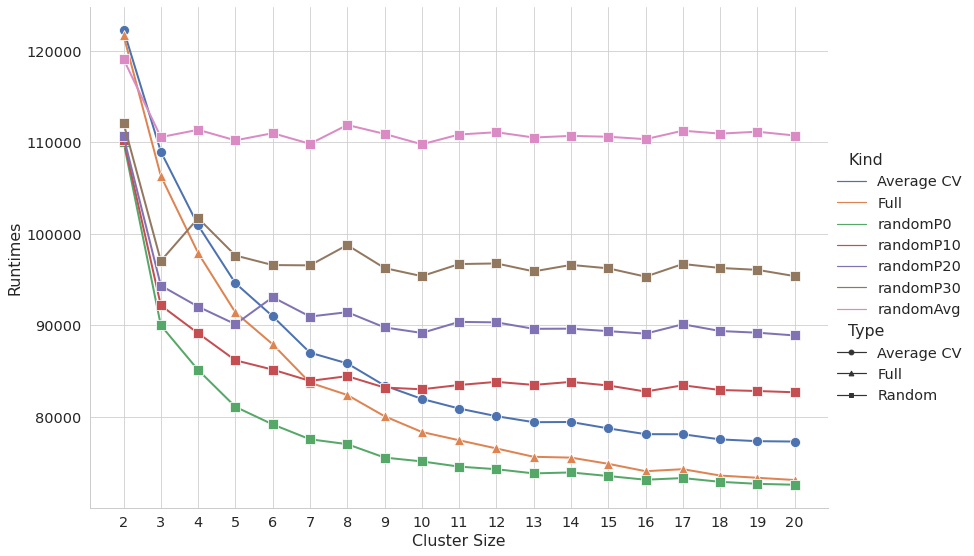

In [258]:
g: sns.FacetGrid = sns.relplot(kind="line",
                               data=data,
                               x="clusterSize",
                               y="res",
                               ci=None,
                               style="Type",
                               markers=["o", "^", "s"],
                               dashes=False,
                               hue="Kind",
                               aspect=1.5,
                               height=8,
                               lw=2,
                               ms=10,
                               )
#sns.move_legend(g, "center left", bbox_to_anchor=(0.82,0.5))#, markerscale=20)
#plt.setp(g.ax.get_legend(), markerscale=2)
#g = g.add_legend(markerscale=2)
g.set(xlabel="Cluster Size", ylabel="Runtimes")
g.ax.set_xticks(range(2, 21))
save_plot(g, "compCVFullRandom")
plt.show()

# [END] trying out new visualisation

In [ ]:
descByMethod = bigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByMethod

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
descByModel = bigtable[bigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
bisModel = descByModel.index[0]
bigtable = bigtable.query("schedType == 'random' or regModel==@bisModel")

In [ ]:
descByMethodSansRand = bigtable[bigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=bigtable[bigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()



In [ ]:
wfNames = cvBigtable.wfName.unique()

In [ ]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [ ]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)

In [ ]:
cvDescByMethod = cvBigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByMethod

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
cvDescByModel = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 1), ncol=5, title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"cv.res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(0.75, 0.45), title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
# bisModel = descByModel.index[0]
comp = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel", "cvSplit"])["res"].describe()
comp = comp.sort_values(by=["mean"], ascending=True)
rM, cvS = comp.reset_index().iloc[0][["regModel", "cvSplit"]]
cvBigtable = cvBigtable.query("schedType == 'random' or (regModel==@rM and cvSplit==@cvS)")

In [ ]:
cvDescByMethodSansRand = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=cvBigtable[cvBigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()
